# LDA Topic Model Evaluation

This notebook focuses on evaluating various LDA (Latent Dirichlet Allocation) models to identify the optimal number of topics and other hyperparameters.

## Imports

In [8]:
import tmtoolkit
from tmtoolkit.topicmod.tm_sklearn import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import random 
import numpy as np
import math
from IPython.display import clear_output
import string
from matplotlib import cm
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib
from tmtoolkit.bow.bow_stats import doc_lengths
from tqdm import tqdm
from scipy.spatial import distance
from tmtoolkit.topicmod.model_stats import word_distinctiveness, most_distinct_words, least_distinct_words

## Data Loading and Preprocessing

In [9]:
def cv_token_return(doc):
    return doc

wordvect = pickle.load(open("output/wordvect.pickel", "rb"))
dtm = pickle.load(open("output/dtm.pickel", "rb"))


data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
r, c = data.shape
print(f"The data has {r} row and {c} columns")

The data has 363 row and 3 columns


In [10]:
var_params = [{'n_components': k, 'doc_topic_prior': 1/k}
            for k in range(2, 20, 2)]

## Model Parameters

We define the parameters for our LDA models. This includes both constant and variable parameters.

In [11]:
const_params = {
    'max_iter':250, # Max learning iterations
    'learning_method':'batch',   
    'random_state':20191122, # Random state
    'batch_size':128,  # n docs in each learning iter
    'evaluate_every':10, # compute perplexity every n iters, default: Don't
    'n_jobs':1,  # to make results reproducible
    'topic_word_prior': 0.1               # sometimes also called "beta"
}

eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=10,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True,
                                     n_max_processes=32)

eval_results[:3]  # only show first three models

pickle.dump(eval_results, open("output/eval_results_100.pickel", "wb"))

In [12]:
eval_results = pickle.load(open("output/eval_results_100.pickel", "rb"))

## Model Evaluation

In [13]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_components')
eval_results_by_topics[:4]  # again only the first three models

[(2,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.5, evaluate_every=10, max_iter=250,
                             n_components=2, n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 460.5534167848993,
   'cao_juan_2009': 0.17587605026038744,
   'coherence_mimno_2011': -484.8993030908042}),
 (4,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.25, evaluate_every=10, max_iter=250,
                             n_components=4, n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 449.8801232770969,
   'cao_juan_2009': 0.21313488152340723,
   'coherence_mimno_2011': -455.8303024270864}),
 (6,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.16666666666666666,
                             evaluate_every=10, max_iter=250, n_components=6,
                             n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 437.

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


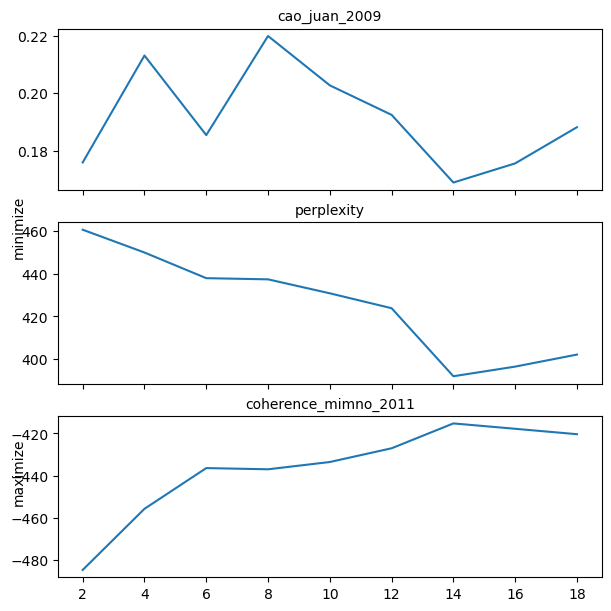

In [14]:
plot_eval_results(eval_results_by_topics);

In [15]:
best_tm = [m for k, m in eval_results_by_topics if k == 6][0]['model']
best_tm.n_components, best_tm.doc_topic_prior, best_tm.topic_word_prior  # just to make sure

(6, 0.16666666666666666, 0.1)

In [16]:
# Show top n keywords for each topic
def show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=15)# Topic - Keywords Dataframe

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels)

['electricity.detection.framework.methods.distribution', 'wind.building.architecture.buildings.sensor', 'communication.technologies.intelligence.vehicle.countries', 'machine.cloud.information.city.internet', 'process.sources.generation.home.time', 'cities.research.demand.load.challenges']


### Document distribution over Time

In [ ]:
cmap = cm.get_cmap('tab20')
data["date"] = data.date.apply(lambda x: x.strip()[0:3] + "0")

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(best_tm.transform(dtm), columns=topic_labels), data["date"]], axis=1)
aggregated_data = combined_array.groupby('datee').mean().reset_index()
aggregated_data.set_index('date', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

plt.show()

In [18]:
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(best_tm, dtm, wordvect)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Results and Visualization

In [19]:
doc_lengths_bg = doc_lengths(dtm)
marg_topic = marginal_topic_distrib(best_tm.transform(dtm), doc_lengths_bg)

### Saliency

In [20]:
word_distinct = word_distinctiveness(best_tm.components_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([0.97711778, 1.12655957, 0.52891001, 1.3678616 , 0.67208739,
       0.53135583, 1.72731205, 0.9636241 , 1.6429356 , 0.66292924])

In [21]:
most_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=30)

array(['process', 'comfort', 'cities', 'user', 'research', 'concepts',
       'cloud', 'stability', 'resource', 'communication', 'structure',
       'market', 'recognition', 'software', 'machine_learning',
       'intelligence', 'coal', 'countries', 'framework', 'power_system',
       'vehicles', 'irrigation', 'people', 'home', 'world', 'time',
       'generation', 'enterprises', 'agriculture', 'problems'],
      dtype=object)

In [22]:
least_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=30)

array(['everything', 'part', 'towards', 'reliability', 'concern',
       'optimization', 'project', 'techniques_techniques', 'century',
       'data_data', 'sensors', 'infrastructures', 'practices', 'storage',
       'development_development', 'smart', 'evaluate', 'cases',
       'irradiance', 'blockchain', 'infrastructure', 'solutions',
       'domains', 'aid', 'developments', 'weather', 'obstacle', 'offer',
       'survey', 'differences'], dtype=object)

### Reliability Analysis

In this subsection, we assess the reliability of our topic models. Reliability is analyzed by examining the overlap between different topic models to calculate a measure of their consistency and stability.

In [23]:
#Compare Model Reliability

final = []

def set_n_to_zero(x, n):
    indexes = np.argpartition(x,-n)[-n:]
    mask = np.ones(x.size, dtype=bool)
    mask[indexes] = False
    x[mask] = 0
    return x

for i in tqdm(range(10)):
    lda_model = pickle.load(open(f'output/lda_model_{i}.pkl', "rb"))
    lda_output = pickle.load(open(f'output/lda_output_{i}.pkl', "rb"))
    final.append(np.apply_along_axis(set_n_to_zero, 1, lda_model.components_, n=20))
        

#make comparison
final = np.asarray(final)
final.shape

100%|██████████| 10/10 [00:00<00:00, 85.57it/s]


(10, 6, 479)

In [24]:
lda_model.components_

array([[ 0.        , 39.16464405, 30.3578201 , ...,  0.        ,
         0.        ,  0.        ],
       [23.14913756,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.97324993, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.83304277,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
final[1,:,:].shape[0]

6

In [30]:
compare = np.zeros((final[1,:,:].shape[0], final[1,:,:].shape[0]))

all_models_reli = []
min_sim = 0.41
vocab = wordvect.get_feature_names_out()

for k in range(10):
    for l in range(10):
        if(k!=l):
            for i in range(final[k,:,:].shape[0]):
                for j in range(final[l,:,:].shape[0]):
                    compare[i,j] = (1 - distance.cosine(final[k,i,:],final[l,j,:]))

            stopped = False
            total_overlap = 0


            while(stopped != True):
                index = np.unravel_index(compare.argmax(), compare.shape)
                #print(index)
                total_overlap += 1
                if(compare[index] < min_sim):
                    stopped = True
                    #print(vocab[np.argsort(-np.array(final[k,index[0],:]))[1:20]])
                    #print(vocab[np.argsort(-np.array(final[l,index[1],:]))[1:20]])
                    #print("#####\n")
                compare[index[0],:] = 0
                compare[index[1],:] = 0

            all_models_reli.append(total_overlap/final[1,:,:].shape[0])

np.asarray(all_models_reli).mean()

0.4074074074074074

In [31]:
np.asarray(all_models_reli)

array([0.5       , 0.33333333, 0.66666667, 0.33333333, 0.16666667,
       0.5       , 0.33333333, 0.33333333, 0.33333333, 0.66666667,
       0.5       , 0.5       , 0.5       , 0.33333333, 0.66666667,
       0.33333333, 0.5       , 0.33333333, 0.33333333, 0.5       ,
       0.5       , 0.33333333, 0.5       , 0.16666667, 0.16666667,
       0.33333333, 0.5       , 0.66666667, 0.33333333, 0.5       ,
       0.66666667, 0.33333333, 0.33333333, 0.66666667, 0.5       ,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.5       ,
       0.33333333, 0.33333333, 0.33333333, 0.66666667, 0.5       ,
       0.16666667, 0.33333333, 0.5       , 0.33333333, 0.33333333,
       0.16666667, 0.33333333, 0.66666667, 0.33333333, 0.83333333,
       0.5       , 0.16666667, 0.33333333, 0.33333333, 0.16666667,
       0.66666667, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.16666667, 0.66666667, 0.33333333, 0.33333333, 0.5       ,
       0.33333333, 0.33333333, 0.33333333, 0.5       , 0.33333

### Word Intrusion Analysis

Word intrusion is a method to evaluate the quality of topics generated by a topic model. In this analysis, we introduce an "intruder" word into a list of words that belong to a specific topic. If the model is good, the intruder word should be easily identifiable as not belonging to the topic.

In [32]:
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
topic = "random"
setsize = 5
chance_correction = False

for iter in range(runs):
    print(f'Word intrusion {iter} of runs\n')
    # select a topic
    if (topic == "random"):
      k = random.randint(0, K)
    else:
      k <- topic

    # select setsize - 1 most probable words
    top_words = np.argsort(best_tm.components_[k-1,:])[::-1]
    top_words_setsize = wordvect.get_feature_names_out()[top_words[:setsize]]
    
    
    
    # select intruder word with low probability from current topic, but high probability in some other topic
    V = best_tm.components_.shape[1]
    top30 = min(V, 30)
    
    high_prob_terms = []
    
    for i in range(K):
        if(i != k):
            top_words_i = np.argsort(best_tm.components_[i,:])[::-1]
            top_words_setsize_i = wordvect.get_feature_names_out()[top_words_i[:top30]]
            high_prob_terms.append(top_words_setsize_i)
    
    high_prob_terms = set(np.unique(np.asarray(high_prob_terms).flatten()))
    low_prob_terms = set(wordvect.get_feature_names_out()[top_words[math.ceil(0.25 * V):V]])
    selection_terms = high_prob_terms & low_prob_terms

    intruder = random.choices(list(selection_terms), k=1)
    
    eval_list = np.insert(
        top_words_setsize,
        random.randint(0, len(top_words_setsize)), 
        intruder)
    intruder_true_position = np.where(eval_list == intruder)[0]

    for j in range(setsize): 
        print(f"[{j}]{eval_list[j]}\n")
    
    intruder_user_selection = int(input("Enter your input: "))
    #clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
        
    
        
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")
    #print(top_words_setsize)
    #print(intruder)

Word intrusion 0 of runs

[0]recognition

[1]cities

[2]research

[3]demand

[4]load

FALSE SELECTION

Word intrusion 1 of runs

[0]plants

[1]machine

[2]cloud

[3]information

[4]city

CORRECT SELECTION

Word intrusion 2 of runs

[0]process

[1]sources

[2]generation

[3]results

[4]home

FALSE SELECTION

Word intrusion 3 of runs

[0]electricity

[1]approach

[2]detection

[3]framework

[4]methods

FALSE SELECTION

Word intrusion 4 of runs

[0]cities

[1]research

[2]demand

[3]load

[4]buildings

FALSE SELECTION

Word intrusion 5 of runs

[0]cities

[1]research

[2]demand

[3]load

[4]challenges

FALSE SELECTION

Word intrusion 6 of runs

[0]process

[1]internet

[2]sources

[3]generation

[4]home

FALSE SELECTION

Word intrusion 7 of runs

[0]issues

[1]process

[2]sources

[3]generation

[4]home

CORRECT SELECTION

Word intrusion 8 of runs

[0]machine

[1]plants

[2]cloud

[3]information

[4]city

CORRECT SELECTION

Word intrusion 9 of runs

[0]electricity

[1]detection

[2]events

In [ ]:
# mean
np.mean(np.array([0.4,0.6,0.2,0.5,0.3]))

0.4

### Topic Keywords

Below, we list the top keywords for each topic generated by our LDA model. These keywords give us a glimpse into the thematic structure of the topics.

In [33]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=15)# Topic - Keywords Dataframe

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels)

['electricity.detection.framework.methods.distribution', 'wind.building.architecture.buildings.sensor', 'communication.technologies.intelligence.vehicle.countries', 'machine.cloud.information.city.internet', 'process.sources.generation.home.time', 'cities.research.demand.load.challenges']


### Topic Intrusion Analysis

Topic intrusion is a method to evaluate the quality of topics within documents generated by a topic model. For this analysis, an "intruder" topic is introduced into a list of topics relevant to a specific document. A good topic model should make it clear that the intruder topic does not belong to the document.

In [34]:
# Topic instrusion
theta = best_tm.transform(dtm)
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
n_docs = theta.shape[0]
chance_correction = False
docs = random.sample(range(n_docs), runs)
setsize = 3

for iter in range(runs):
    d = docs[iter]

    print(f"Topic intrusion {iter} of {runs}\n")
    
    doc_text = data.abstract[d]
    
    # select setsize - 1 most probable topic
    top_topics = np.argsort(theta[d,:])[::-1]
    top_topic_names = [label for idx, label in enumerate(topic_labels) if idx in top_topics[:(setsize-1)]]
    intruder_topic = random.choices(list(top_topics[math.ceil((K+1)/2):K-1]), k=1)
    intruder_topic_name = topic_labels[intruder_topic[0]]
    
    eval_list = np.insert(
        top_topic_names,
        random.randint(0, len(top_topic_names)), 
        intruder_topic_name)
    
    intruder_true_position = np.where(eval_list == intruder_topic_name)[0]
    
    print(f'{doc_text}\n')
    
    for i in range(setsize): 
        print(f"[{i}] {eval_list[i]}\n")

    intruder_user_selection = int(input("Enter your input: "))
    clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
    
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")

FALSE SELECTION

Performance: 0.3 (3 out of 10 runs)



In [15]:
# mean
np.mean(np.array([0.4,0.2,0.2,0.6,0.3]))

0.33999999999999997